In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math, random

## 필요한 변수 정의

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 64
EPOCHS = 30

## 데이터 준비하기

### 데이터 불러오기

In [3]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))
test_filenames = tf.io.gfile.glob(TEST_PATH)

### train / val 데이터 나누기

In [4]:
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### 데이터 전처리

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_NORMAL
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(COUNT_NORMAL, "/", COUNT_PNEUMONIA)

1072 / 3113


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
def get_label(filename):
    file_path = tf.strings.split(filename, os.path.sep)
    return file_path[-2] == "PNEUMONIA"
        
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

def process_file(filename):
    label = get_label(filename)
    image = tf.io.read_file(filename)
    image = decode_image(image)
    return image, label

In [9]:
train_ds = train_list_ds.map(process_file, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_file, num_parallel_calls=AUTOTUNE)

In [10]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [11]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)

TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_file, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [12]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

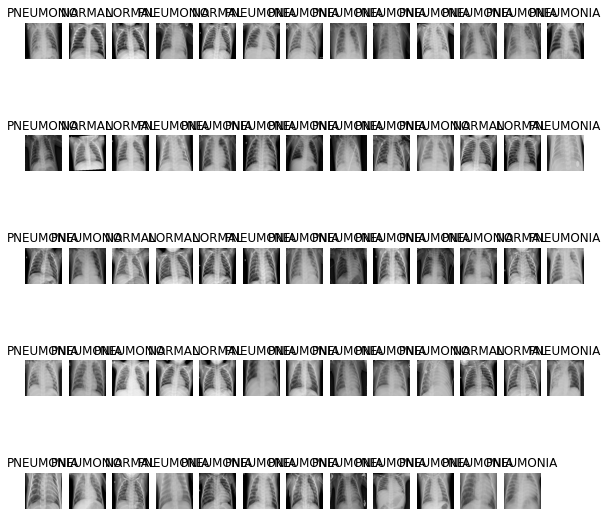

In [13]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 모델링

In [14]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation="relu", padding="same"),
        tf.keras.layers.SeparableConv2D(filters, 3, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [15]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [16]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}


In [17]:
with tf.device('/GPU:0'):
    model = build_model()
    
    MATRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=MATRICS
    )

In [18]:
with tf.device("/GPU:0"):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/30
65/65 [==============================] - 54s 511ms/step - loss: 0.5347 - accuracy: 0.7434 - precision: 0.9162 - recall: 0.7145 - val_loss: 0.5811 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/30
65/65 [==============================] - 32s 492ms/step - loss: 0.1953 - accuracy: 0.9250 - precision: 0.9870 - recall: 0.9133 - val_loss: 0.7538 - val_accuracy: 0.7393 - val_precision: 0.7393 - val_recall: 1.0000
Epoch 3/30
65/65 [==============================] - 31s 487ms/step - loss: 0.1433 - accuracy: 0.9527 - precision: 0.9873 - recall: 0.9492 - val_loss: 0.8905 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 4/30
65/65 [==============================] - 31s 478ms/step - loss: 0.1255 - accuracy: 0.9554 - precision: 0.9847 - recall: 0.9550 - val_loss: 1.0057 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/30
65/65 [==============================] - 32s 499ms/step - loss: 0.1070 - accuracy: 0.9599

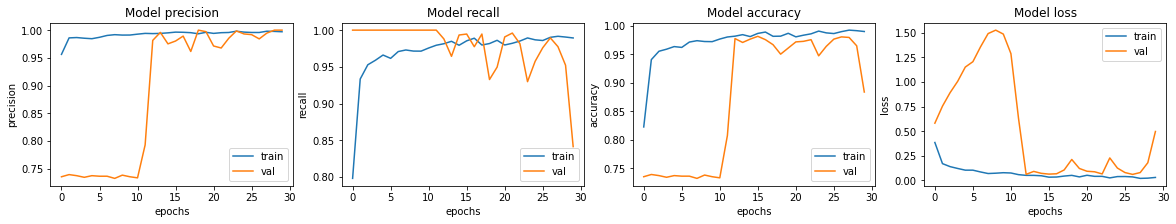

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_"+met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 9s 904ms/step - loss: 0.6723 - accuracy: 0.8446 - precision: 0.8547 - recall: 0.9051
Loss: 0.6722609400749207,
Accuracy: 0.8445512652397156,
Precision: 0.8547215461730957,
Recall: 0.9051281809806824
